# 1.导入模块及数据集

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

# plt设置中文
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'使用设备: {device}')

# 下载MNIST数据集
transform = transforms.Compose([
    transforms.ToTensor(),  # 将PIL图像或numpy.ndarray转换为Tensor，并归一化到[0, 1]
    transforms.Normalize((0.1307,), (0.3081,)) # 归一化处理，MNIST数据集的均值和标准差
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

使用设备: cuda


# 2.加载和归一化图像数据

In [2]:
# 创建数据加载器
batch_size = 2000
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 获取一批数据来查看形状
data_iter = iter(train_loader)  # iter 函数用于创建迭代器
images, labels = next(data_iter) # 获取一批数据

print("Feature matrix (x_train):", images.shape)
print("Target matrix (y_train):", labels.shape)
print("训练集大小:", len(train_dataset))
print("测试集大小:", len(test_dataset))

# 将数据转换为numpy用于可视化
x_train_vis = train_dataset.data.numpy()
y_train_vis = train_dataset.targets.numpy()
x_test_vis = test_dataset.data.numpy()
y_test_vis = test_dataset.targets.numpy()

print("可视化用数据形状:")
print("x_train_vis:", x_train_vis.shape)
print("y_train_vis:", y_train_vis.shape)

Feature matrix (x_train): torch.Size([2000, 1, 28, 28])
Target matrix (y_train): torch.Size([2000])
训练集大小: 60000
测试集大小: 10000
可视化用数据形状:
x_train_vis: (60000, 28, 28)
y_train_vis: (60000,)


# 3.可视化数据

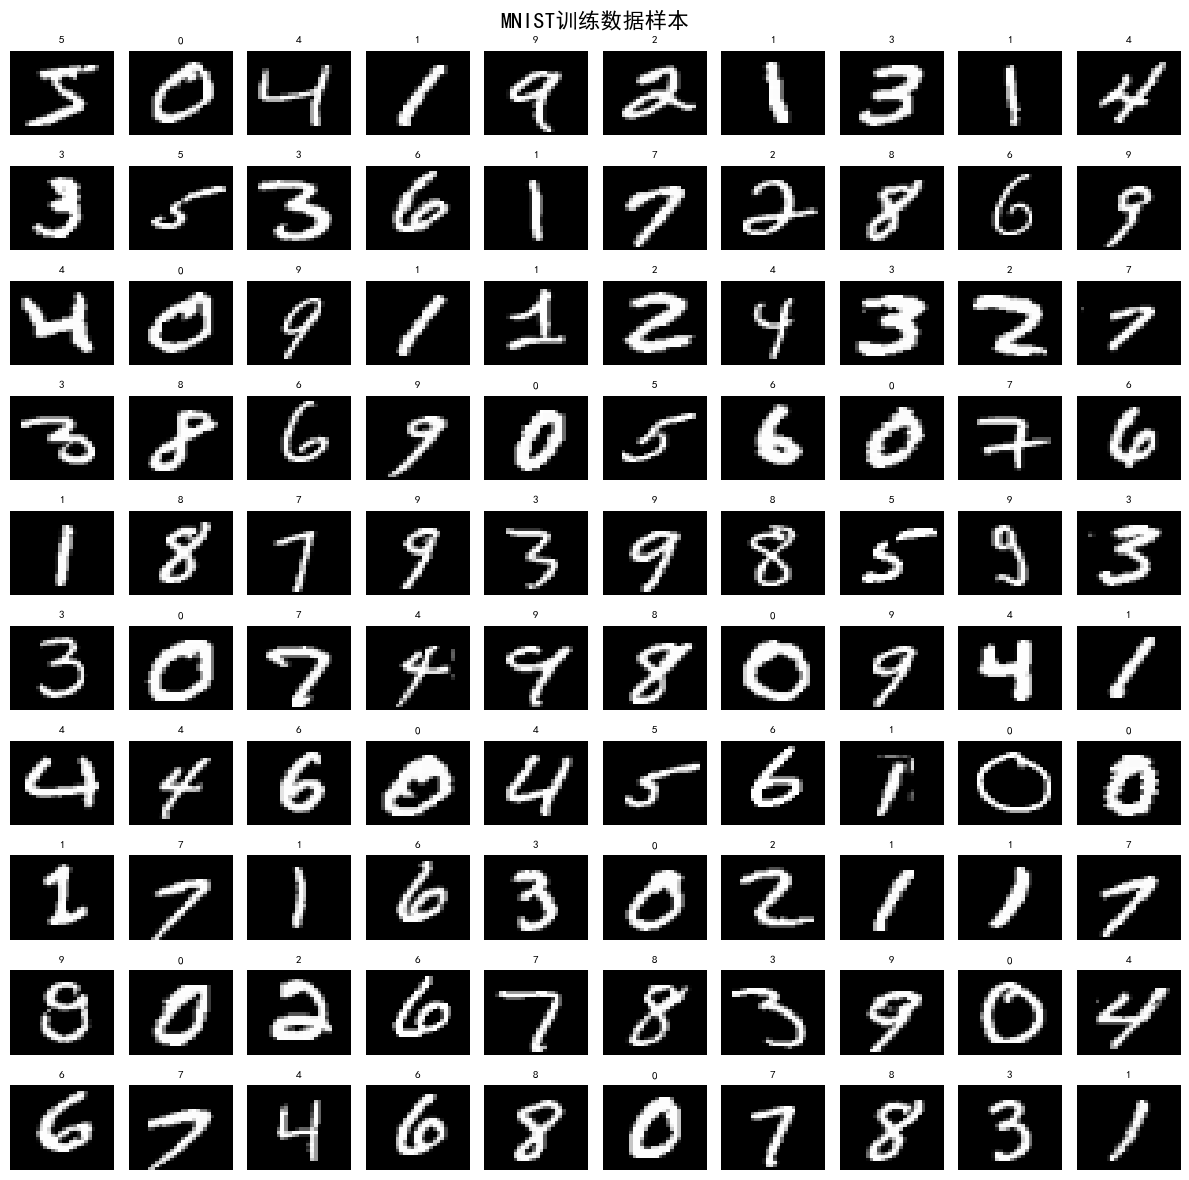

In [3]:
fig, ax = plt.subplots(10, 10, figsize=(12, 12))
k = 0
for i in range(10):
    for j in range(10):
        # 使用原始数据进行可视化（未归一化的）
        ax[i][j].imshow(x_train_vis[k], cmap='gray', aspect='auto')
        ax[i][j].set_title(f'{y_train_vis[k]}', fontsize=8)
        ax[i][j].axis('off')
        k += 1
plt.suptitle('MNIST训练数据样本', fontsize=16)
plt.tight_layout()
plt.show()

# 4.构建神经网络模型

In [4]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        x = self.flatten(x)
        x = self.sigmoid(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        x = self.fc3(x)  # 不在这里应用softmax，因为CrossEntropyLoss会处理
        return x

# 创建模型实例
model = MLP().to(device)
print(model)

# 打印模型参数数量
total_params = sum(p.numel() for p in model.parameters())
print(f"模型总参数数量: {total_params:,}")

MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=1)
)
模型总参数数量: 235,146


# 5.编译模型

In [5]:
# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("损失函数:", criterion)
print("优化器:", optimizer)

损失函数: CrossEntropyLoss()
优化器: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


# 6.训练模型

In [6]:
# 训练参数
epochs = 10
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# 创建验证集（从训练数据中分离20%）
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

train_loader_split = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

print(f"训练集大小: {len(train_subset)}")
print(f"验证集大小: {len(val_subset)}")

# 训练循环
for epoch in range(epochs):
    # 训练阶段
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (data, targets) in enumerate(train_loader_split):
        data, targets = data.to(device), targets.to(device)
        
        # 前向传播
        outputs = model(data)
        loss = criterion(outputs, targets)
        
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # 统计
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0) # 计算总样本数
        correct += (predicted == targets).sum().item()
    
    train_loss = running_loss / len(train_loader_split)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    # 验证阶段
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for data, targets in val_loader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            loss = criterion(outputs, targets)
            
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += targets.size(0)
            val_correct += (predicted == targets).sum().item()
    
    val_loss = val_running_loss / len(val_loader)
    val_acc = 100 * val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    print(f'Epoch [{epoch+1}/{epochs}] - '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% - '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

print("训练完成！")

训练集大小: 48000
验证集大小: 12000
Epoch [1/10] - Train Loss: 2.0685, Train Acc: 43.50% - Val Loss: 1.7118, Val Acc: 66.13%
Epoch [1/10] - Train Loss: 2.0685, Train Acc: 43.50% - Val Loss: 1.7118, Val Acc: 66.13%
Epoch [2/10] - Train Loss: 1.3498, Train Acc: 73.53% - Val Loss: 1.0100, Val Acc: 77.87%
Epoch [2/10] - Train Loss: 1.3498, Train Acc: 73.53% - Val Loss: 1.0100, Val Acc: 77.87%
Epoch [3/10] - Train Loss: 0.7980, Train Acc: 83.94% - Val Loss: 0.6279, Val Acc: 87.43%
Epoch [3/10] - Train Loss: 0.7980, Train Acc: 83.94% - Val Loss: 0.6279, Val Acc: 87.43%
Epoch [4/10] - Train Loss: 0.5244, Train Acc: 89.03% - Val Loss: 0.4468, Val Acc: 89.85%
Epoch [4/10] - Train Loss: 0.5244, Train Acc: 89.03% - Val Loss: 0.4468, Val Acc: 89.85%
Epoch [5/10] - Train Loss: 0.3914, Train Acc: 90.86% - Val Loss: 0.3571, Val Acc: 91.15%
Epoch [5/10] - Train Loss: 0.3914, Train Acc: 90.86% - Val Loss: 0.3571, Val Acc: 91.15%
Epoch [6/10] - Train Loss: 0.3210, Train Acc: 91.96% - Val Loss: 0.3078, Val Acc: 92

# 7.评估模型

In [7]:
# 在测试集上评估模型
model.eval()
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():  # 在测试集上不需要计算梯度
    for data, targets in test_loader:
        data, targets = data.to(device), targets.to(device)
        outputs = model(data)
        loss = criterion(outputs, targets)
        
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)  # 获取预测结果
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.2f}%')
print(f'Test loss, Test accuracy: [{test_loss:.4f}, {test_accuracy/100:.4f}]')

Test Loss: 0.2025
Test Accuracy: 94.41%
Test loss, Test accuracy: [0.2025, 0.9441]


# 8.可视化训练和验证损失与准确性

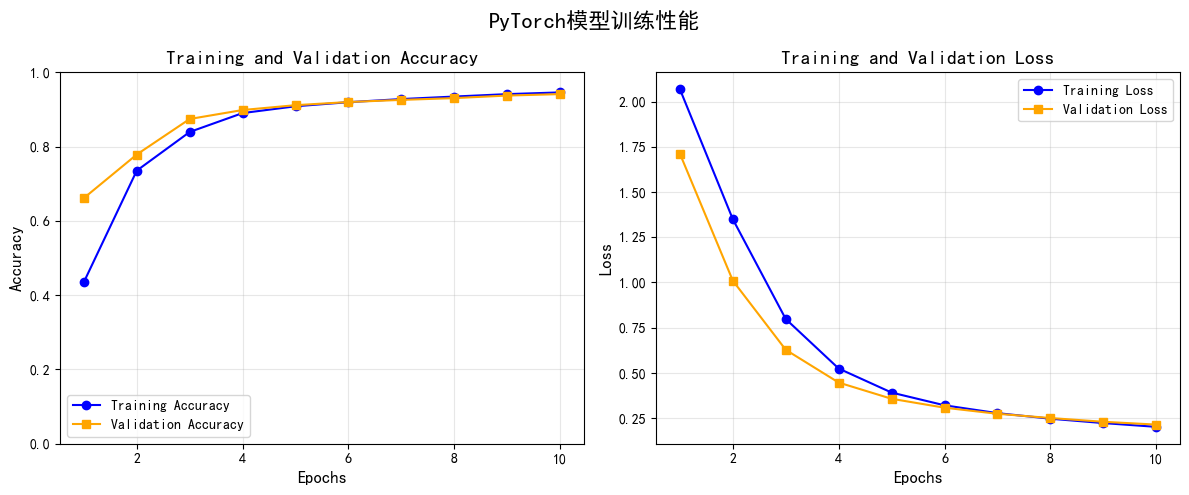


=== 训练总结 ===
最终训练准确率: 94.59%
最终验证准确率: 94.13%
测试准确率: 94.41%
最终训练损失: 0.2020
最终验证损失: 0.2144
测试损失: 0.2025


In [8]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), [acc/100 for acc in train_accuracies], label='Training Accuracy', color='blue', marker='o')
plt.plot(range(1, epochs+1), [acc/100 for acc in val_accuracies], label='Validation Accuracy', color='orange', marker='s')
plt.title('Training and Validation Accuracy', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 1)

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_losses, label='Training Loss', color='blue', marker='o')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss', color='orange', marker='s')
plt.title('Training and Validation Loss', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

plt.suptitle("PyTorch模型训练性能", fontsize=16)
plt.tight_layout()
plt.show()

# 打印最终结果总结
print(f"\n=== 训练总结 ===")
print(f"最终训练准确率: {train_accuracies[-1]:.2f}%")
print(f"最终验证准确率: {val_accuracies[-1]:.2f}%")
print(f"测试准确率: {test_accuracy:.2f}%")
print(f"最终训练损失: {train_losses[-1]:.4f}")
print(f"最终验证损失: {val_losses[-1]:.4f}")
print(f"测试损失: {test_loss:.4f}")

In [9]:
# 9. 保存训练好的模型
import os

# 创建模型保存目录
model_dir = "saved_models"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# 保存完整模型
model_path = os.path.join(model_dir, "mlp_mnist_model.pth")
torch.save(model.state_dict(), model_path)
print(f"模型已保存到: {model_path}")

# 也可以保存完整的模型信息（包括模型结构）
full_model_path = os.path.join(model_dir, "mlp_mnist_full_model.pth")
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': epochs,
    'train_accuracy': train_accuracies[-1],
    'val_accuracy': val_accuracies[-1],
    'test_accuracy': test_accuracy
}, full_model_path)
print(f"完整模型信息已保存到: {full_model_path}")

模型已保存到: saved_models\mlp_mnist_model.pth
完整模型信息已保存到: saved_models\mlp_mnist_full_model.pth


# 10. 加载保存的模型

In [10]:
# 加载保存的模型函数
def load_model(model_path):
    """加载保存的模型"""
    # 创建新的模型实例
    loaded_model = MLP().to(device)
    
    # 加载模型参数
    loaded_model.load_state_dict(torch.load(model_path, map_location=device))
    loaded_model.eval()  # 设置为评估模式
    
    return loaded_model

# 示例：加载刚刚保存的模型
# loaded_model = load_model(model_path)
# print("模型加载成功！")

# 加载完整模型信息的函数
def load_full_model_info(full_model_path):
    """加载完整的模型信息"""
    checkpoint = torch.load(full_model_path, map_location=device)
    
    # 创建模型并加载参数
    loaded_model = MLP().to(device)
    loaded_model.load_state_dict(checkpoint['model_state_dict'])
    loaded_model.eval()
    
    # 打印保存的训练信息
    print(f"模型训练轮数: {checkpoint['epoch']}")
    print(f"训练准确率: {checkpoint['train_accuracy']:.2f}%")
    print(f"验证准确率: {checkpoint['val_accuracy']:.2f}%")
    print(f"测试准确率: {checkpoint['test_accuracy']:.2f}%")
    
    return loaded_model, checkpoint

# 示例：加载完整模型信息
# loaded_model, checkpoint = load_full_model_info(full_model_path)

# 11. 自定义手写数字测试

In [14]:
from PIL import Image
import cv2

def preprocess_custom_image(image_path):
    """
    预处理自定义手写数字图片
    Args:
        image_path: 图片路径
    Returns:
        preprocessed_tensor: 预处理后的tensor
    """
    # 读取图片
    if isinstance(image_path, str):
        # 如果是文件路径，读取图片
        img = Image.open(image_path).convert('L')  # 转换为灰度图
    else:
        # 如果是numpy数组
        img = Image.fromarray(image_path).convert('L')
    
    # 调整图片大小为28x28
    img = img.resize((28, 28), Image.Resampling.LANCZOS)
    
    # 转换为numpy数组
    img_array = np.array(img)
    
    # 反转颜色（如果背景是白色，数字是黑色，需要反转）
    # MNIST数据集是黑色背景，白色数字
    # 如果你的图片是白色背景，黑色数字，取消下面这行的注释
    # img_array = 255 - img_array
    
    # 归一化到[0, 1]
    img_array = img_array.astype(np.float32) / 255.0
    
    # 应用与训练时相同的标准化
    img_array = (img_array - 0.1307) / 0.3081
    
    # 转换为torch tensor并添加batch维度
    img_tensor = torch.from_numpy(img_array).unsqueeze(0).unsqueeze(0)  # (1, 1, 28, 28)
    
    return img_tensor.to(device)

def predict_custom_digit(model, image_path, show_image=True):
    """
    预测自定义手写数字
    Args:
        model: 训练好的模型
        image_path: 图片路径
        show_image: 是否显示图片
    Returns:
        predicted_digit: 预测的数字
        confidence: 置信度
    """
    # 预处理图片
    img_tensor = preprocess_custom_image(image_path)
    
    # 预测
    model.eval()
    with torch.no_grad():
        output = model(img_tensor)
        probabilities = F.softmax(output, dim=1)
        predicted_digit = torch.argmax(output, dim=1).item()
        confidence = probabilities[0][predicted_digit].item()
    
    if show_image:
        # 显示处理后的图片
        img_display = img_tensor.cpu().squeeze().numpy()
        plt.figure(figsize=(6, 3))
        
        plt.subplot(1, 2, 1)
        # 显示原始图片
        if isinstance(image_path, str):
            original_img = Image.open(image_path).convert('L')
            plt.imshow(original_img, cmap='gray')
            plt.title('原始图片')
        else:
            plt.imshow(image_path, cmap='gray')
            plt.title('原始图片')
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        # 显示预处理后的图片
        plt.imshow(img_display, cmap='gray')
        plt.title(f'预处理后图片\n预测: {predicted_digit} (置信度: {confidence:.2%})')
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
    
    return predicted_digit, confidence

print("图像预处理和预测函数已定义完成！")

图像预处理和预测函数已定义完成！


创建测试数字...


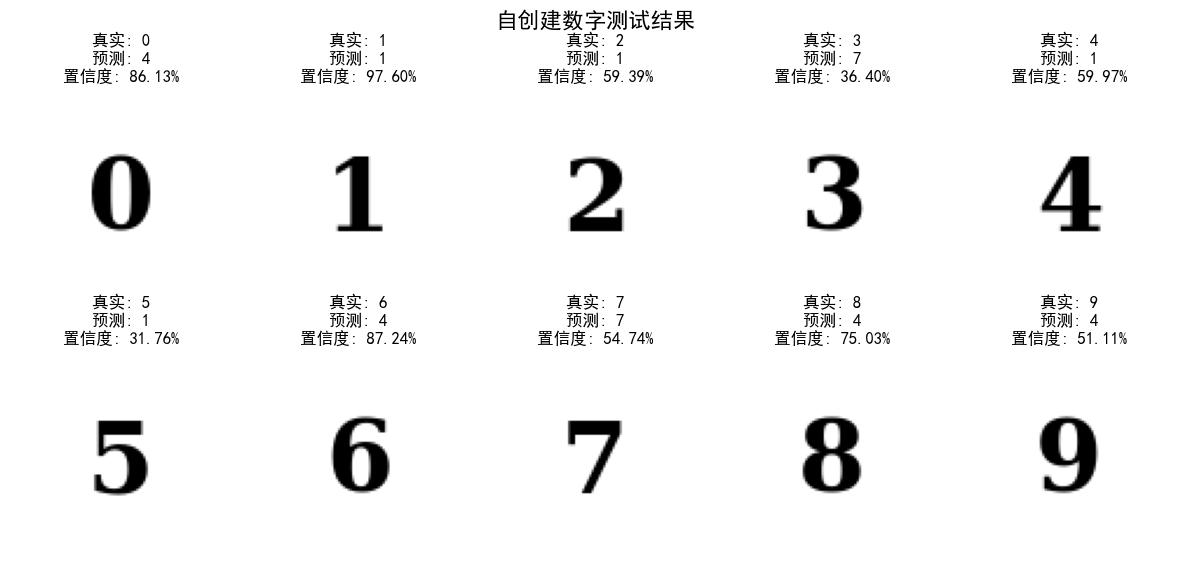

测试完成！你可以用同样的方法测试你自己的手写数字图片。


In [12]:
# 创建一个简单的手写数字图片用于测试
def create_test_digit(digit, size=(100, 100)):
    """
    创建一个简单的测试数字图片
    Args:
        digit: 要创建的数字 (0-9)
        size: 图片大小
    Returns:
        numpy array: 图片数组
    """
    import matplotlib.patches as patches
    
    fig, ax = plt.subplots(figsize=(2, 2))
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)
    ax.axis('off')
    
    # 设置白色背景
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')
    
    # 用黑色绘制数字
    ax.text(5, 5, str(digit), fontsize=60, ha='center', va='center', 
            color='black', weight='bold', family='serif')
    
    # 保存为临时图片
    plt.tight_layout()
    plt.savefig('temp_digit.png', dpi=50, bbox_inches='tight', 
                facecolor='white', edgecolor='none')
    plt.close()
    
    # 读取图片
    img = Image.open('temp_digit.png').convert('L')
    img_array = np.array(img)
    
    # 删除临时文件
    os.remove('temp_digit.png')
    
    return img_array

# 测试自己创建的数字
print("创建测试数字...")
test_digits = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# 显示创建的测试数字
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.flatten()

for i, digit in enumerate(test_digits):
    test_img = create_test_digit(digit)
    
    # 使用模型预测
    predicted_digit, confidence = predict_custom_digit(model, test_img, show_image=False)
    
    # 显示图片和预测结果
    axes[i].imshow(test_img, cmap='gray')
    axes[i].set_title(f'真实: {digit}\n预测: {predicted_digit}\n置信度: {confidence:.2%}')
    axes[i].axis('off')

plt.suptitle('自创建数字测试结果', fontsize=16)
plt.tight_layout()
plt.show()

print("测试完成！你可以用同样的方法测试你自己的手写数字图片。")

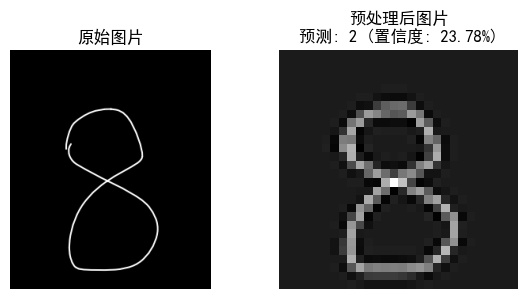

预测结果: 2, 置信度: 23.78%


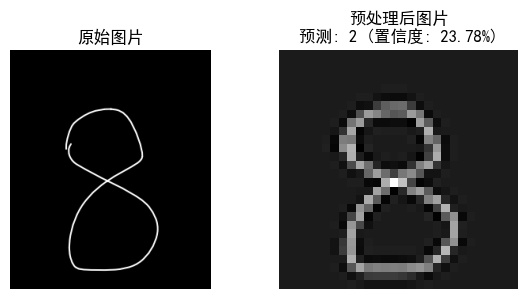

In [15]:
img_path = r"H:\Code\Python\CV\CV_learning\多层感知机MLP\data\MY\8.png"
predicted_digit, confidence = predict_custom_digit(model, img_path)
print(f"预测结果: {predicted_digit}, 置信度: {confidence:.2%}")

# 可视化
# img --- IGNORE ---
img = preprocess_custom_image(img_path)
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.imshow(Image.open(img_path).convert('L'), cmap='gray')
plt.title('原始图片')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(img.cpu().squeeze().numpy(), cmap='gray')
plt.title(f'预处理后图片\n预测: {predicted_digit} (置信度: {confidence:.2%})')
plt.axis('off')
plt.tight_layout()
plt.show()


# 12. 使用自己的手写数字图片进行测试

## 使用方法：

### 1. 准备你的手写数字图片
- 图片格式：支持常见格式（jpg, png, bmp等）
- 图片内容：黑色数字，白色背景（或者白色数字，黑色背景）
- 建议：数字要尽量居中，清晰可见

### 2. 使用模型进行预测
```python
# 方法1：使用图片文件路径
image_path = "your_handwritten_digit.png"  # 替换为你的图片路径
predicted_digit, confidence = predict_custom_digit(model, image_path)
print(f"预测结果: {predicted_digit}, 置信度: {confidence:.2%}")

# 方法2：如果已经加载了保存的模型
loaded_model = load_model("saved_models/mlp_mnist_model.pth")
predicted_digit, confidence = predict_custom_digit(loaded_model, image_path)
```

### 3. 提示
- 如果预测结果不理想，可能需要调整图片的对比度或清晰度
- 确保数字在图片中占据主要区域
- 如果背景和数字的颜色与MNIST相反，函数会自动处理

In [ ]:
# 实际使用示例（请将图片路径替换为你的实际路径）

# 示例：如果你有一个名为 "my_digit.png" 的手写数字图片
# image_path = "my_digit.png"
# predicted_digit, confidence = predict_custom_digit(model, image_path)
# print(f"预测结果: {predicted_digit}, 置信度: {confidence:.2%}")

# 批量测试多个图片的函数
def test_multiple_images(model, image_paths):
    """
    批量测试多个图片
    Args:
        model: 训练好的模型
        image_paths: 图片路径列表
    """
    results = []
    for i, image_path in enumerate(image_paths):
        print(f"\n测试图片 {i+1}: {image_path}")
        try:
            predicted_digit, confidence = predict_custom_digit(model, image_path)
            results.append((image_path, predicted_digit, confidence))
            print(f"预测: {predicted_digit}, 置信度: {confidence:.2%}")
        except Exception as e:
            print(f"处理图片时出错: {e}")
            results.append((image_path, None, None))
    
    return results

# 使用示例（取消注释并替换为你的图片路径）
# image_paths = ["digit1.png", "digit2.png", "digit3.png"]
# results = test_multiple_images(model, image_paths)

print("手写数字测试功能准备完毕！")
print("请将你的手写数字图片放在项目目录中，然后使用上面的函数进行测试。")